**Aggregate MNIST Adv Test Results**

In [27]:
import sys
import os
import glob
import pickle

In [28]:
import pandas as pd

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
import seaborn as sns
sns.set()

In [31]:
agg_results = []
for pkl_file in glob.glob('logs/mnist_adv_test-*.pkl'):
    print("Loading {}...".format(pkl_file))
    with open(pkl_file, 'rb') as f:
        results = pickle.Unpickler(f).load()
        agg_results.extend(results)

# Drop confusion matrix:
for result in agg_results:
    for c in ['confusion_mat', 'confusion_mat_adv']:
        if c in result:
            del result[c]
        
all_cols = set()
score_cols = set()
for result in agg_results:
    cols = set(result.keys())
    all_cols.update(cols)
    for col in cols:
        if col.startswith('test_score'):
            score_cols.add(col)
            
df_cols = list(all_cols - score_cols) + list(score_cols)
df = pd.DataFrame(agg_results, columns=df_cols)

Loading logs/mnist_adv_test-2018-04-03-04-34-29-ip-172-16-0-155-1910.pkl...
Loading logs/mnist_adv_test-2018-04-03-04-38-23-ip-172-16-0-131-1765.pkl...
Loading logs/mnist_adv_test-2018-04-03-04-45-47-ip-172-16-0-187-2117.pkl...
Loading logs/mnist_adv_test-2018-04-03-04-57-32-ip-172-16-0-4-1774.pkl...
Loading logs/mnist_adv_test-2018-04-03-05-38-23-ip-172-16-0-251-2132.pkl...
Loading logs/mnist_adv_test-2018-04-03-05-40-04-ip-172-16-0-6-1844.pkl...
Loading logs/mnist_adv_test-2018-04-03-11-31-15-ip-172-16-0-197-7155.pkl...
Loading logs/mnist_adv_test-2018-04-03-17-48-49-ip-172-16-0-4-3050.pkl...
Loading logs/mnist_adv_test-2018-04-03-17-49-32-ip-172-16-0-155-3649.pkl...
Loading logs/mnist_adv_test-2018-04-03-17-51-17-ip-172-16-0-131-3096.pkl...
Loading logs/mnist_adv_test-2018-04-03-17-51-24-ip-172-16-0-4-3075.pkl...
Loading logs/mnist_adv_test-2018-04-03-17-54-40-ip-172-16-0-155-3696.pkl...
Loading logs/mnist_adv_test-2018-04-03-17-55-18-ip-172-16-0-131-3164.pkl...
Loading logs/mnist_a

In [32]:
# Patch LR by hand, it never finished!

In [33]:
df.sort_values(by=['test_score_adv', 'test_score'], ascending=False, inplace=True)

In [34]:
df_baseline = df[(df['noise'] == "None") & (df['xor_pr'] == False) & (df['train_adv_p'] == 0)]

In [35]:
results_df = df.rename(
    columns={
        'test_score': 'Test Score', 
        'test_score_adv': 'Adv Test Score'
    },
)

In [68]:
# Add strategy column: noise, adv(%), xor
def set_strategy(r):
    if r['noise'] != 'None':
        s = 'noise'
    elif r['train_adv_p'] > 0:
        s = 'adv'
    elif r['xor_pr']:
        s = 'xor'
    else:
        s = 'None'
    return s
    
results_df['strategy'] = results_df.apply(set_strategy, axis=1)

In [69]:
results_df = results_df.groupby(['estimator', 'strategy'], as_index=False).head(2)

In [70]:
def expand_strategy(r):
    if r['strategy'] == 'noise':
        s = r['noise']
    elif r['strategy'] == 'adv':
        s = 'Adv({:.0f}%)'.format(r['train_adv_p']*100.)
    else:
        s = r['strategy']
    return s.upper()

results_df['strategy'] = results_df.apply(expand_strategy, axis=1)      

In [85]:
def plot_results(estimator):

    ax = results_df[results_df['estimator'] == estimator].plot.bar(
        x=['strategy'], 
        y=['Test Score', 'Adv Test Score'],
        figsize=(6, 4),
    )
    base_test_score, base_test_score_adv = \
        df_baseline[df_baseline['estimator'] == estimator][['test_score', 'test_score_adv']].values.flatten()
    ax.plot(
        ax.get_xlim(), [base_test_score, base_test_score], 
        linestyle='--',
        label='Test Score Baseline',
    )
    ax.plot(
        ax.get_xlim(), [base_test_score_adv, base_test_score_adv], 
        linestyle='--',
        label='Adv Test Score Baseline'
    )
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_ylim([0, 1])
    ax.set_ylabel('Score', fontsize=18)
    ax.set_xlabel('')
    ax.set_xticklabels(
        ax.get_xticklabels(), horizontalalignment='right',
        rotation=15,
    )
    ax.set_title('{}'.format(estimator), fontsize=24, loc='left')
    plt.show()

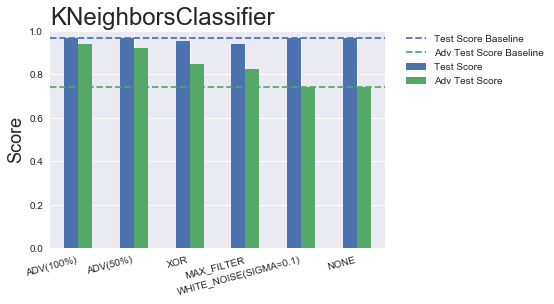

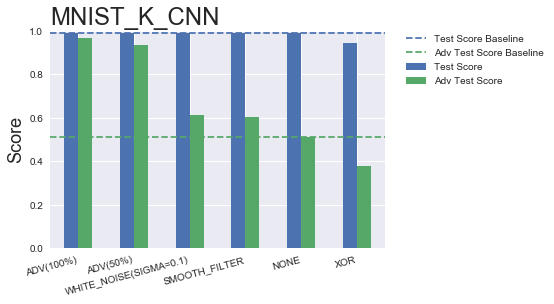

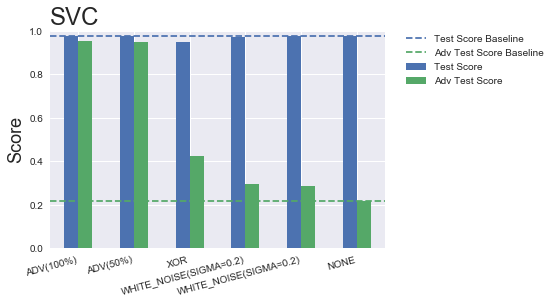

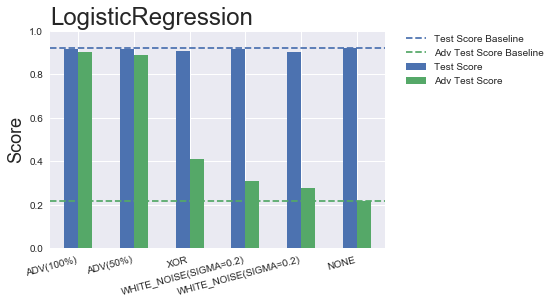

In [86]:
for estimator in df_baseline['estimator'].unique():
    plot_results(estimator)